# Jupyter Notebook for the Module 4 Labs
This notebook explores models based on an image classification model for the Fashion-MNIST dataset using tf.keras and trained using HPE Cray AI Development Environment. Extra code has been added for the purposes of this lab.

Based on: https://www.tensorflow.org/tutorials/keras/classification.



MIT License

Copyright (c) 2017 François Chollet

 Permission is hereby granted, free of charge, to any person obtaining a
 copy of this software and associated documentation files (the "Software"),
 to deal in the Software without restriction, including without limitation
 the rights to use, copy, modify, merge, publish, distribute, sublicense,
 and/or sell copies of the Software, and to permit persons to whom the
 Software is furnished to do so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in
 all copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
 THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
 FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
 DEALINGS IN THE SOFTWARE.

## Module 4-Lab 2

### Set up for validating trained models
This code imports modules, loads validation data (fashion images), and prepares for displaying the results of passing validation images through the model. 
Run the cell below.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import gzip
import tempfile
from tensorflow.python.keras.utils.data_utils import get_file
print("TensorFlow version is "+tf.__version__+".")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_validation_data():
    """Loads the Fashion-MNIST dataset.

    Returns:
        Tuple of Numpy arrays: `(x_test, y_test)`.

    License:
        The copyright for Fashion-MNIST is held by Zalando SE.
        Fashion-MNIST is licensed under the [MIT license](
        https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

    """
    base = "/tmp/data/"
    files = [
        "t10k-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ]

    paths = []
    for fname in files:
        paths.append(base + fname)

    with gzip.open(paths[0], "rb") as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], "rb") as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

    return x_test, y_test

test_images, test_labels = load_validation_data()
test_images = test_images / 255.0
print("Validation data (fashion images) loaded.")

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
set = 0 
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
start_image = (set*num_images)
end_image = (set*num_images)+num_images
print("Display functions defined.")

TensorFlow version is 2.6.2.
Validation data (fashion images) loaded.
Display functions defined.


### Load the trained model (trained on one GPU) 
In line 1 below, replace your_uuid with the checkpoint UUID that you collected during the lab. Make sure to leave the "" around the UUID.
Then run the cell.

In [2]:
const_uuid = "e23aa58d-acc0-4416-bd7b-eef97aa6217d"
const_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10),
])  
const_model.load_weights("/tmp/determined-checkpoint/jear-bucket/"+const_uuid+"/determined-keras-model-weights").expect_partial()

### Run images through the trained model
Run the cell below to run the images through the trained model and display the results.

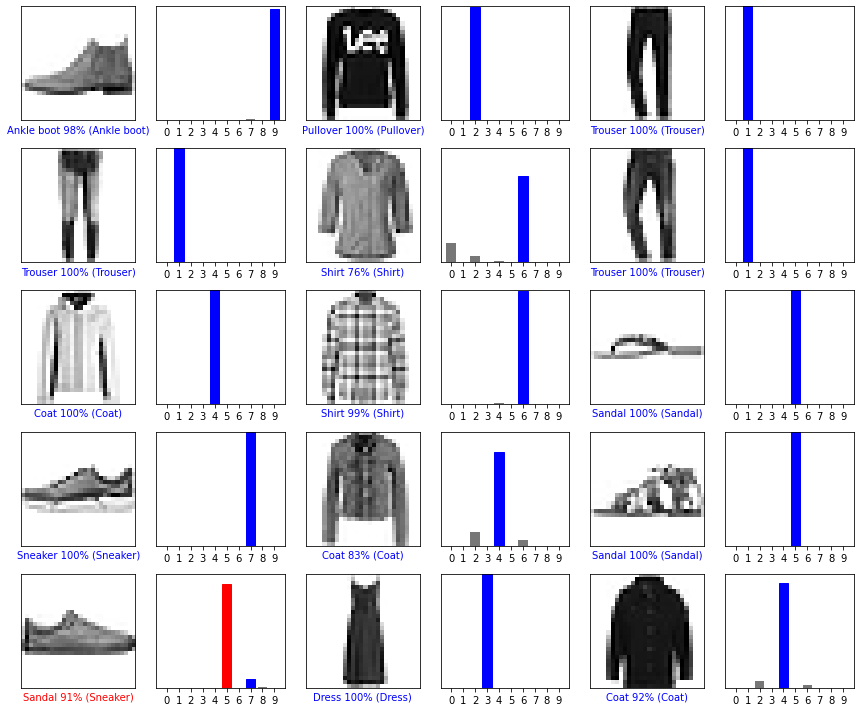

In [3]:
const_probability_model = tf.keras.Sequential([const_model, 
                                         tf.keras.layers.Softmax()])
const_predictions = const_probability_model.predict(test_images)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, const_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, const_predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Stop
You have completed Module 4-Lab 2.

## Module 4-Lab 3

### Load your model trained on multiple GPUs 
In line 1 below, replace your_uuid with the checkpoint UUID that you collected in this lab. Make sure to leave "" around the UUID.
Then run the cell.

In [4]:
distributed_uuid = "d895653e-5018-46a3-aaee-023ef8b071a9"
distributed_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.65),
    tf.keras.layers.Dense(10),])  
distributed_model.load_weights("/tmp/determined-checkpoint/jear-bucket/"+distributed_uuid+"/determined-keras-model-weights").expect_partial()

### Run images through the trained model
Run the cell below to run the images through the trained model and display the results.

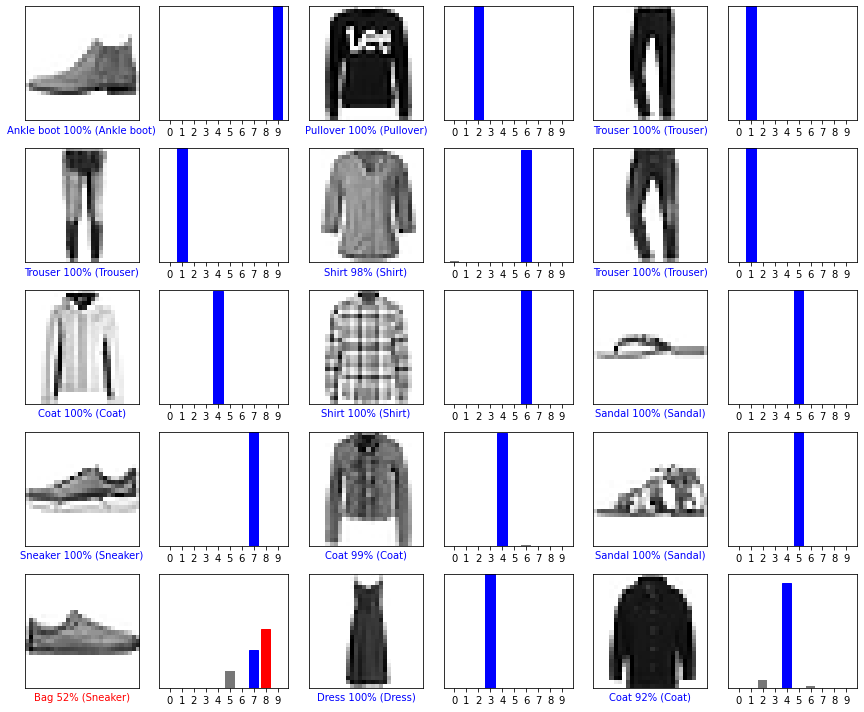

In [5]:
ch_test_images = np.expand_dims(test_images, axis=-1)
distributed_probability_model = tf.keras.Sequential([distributed_model, 
                                         tf.keras.layers.Softmax()])
distributed_predictions = distributed_probability_model.predict(ch_test_images)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, distributed_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, distributed_predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Stop
You have completed Module 4-Lab 3.

## Module 4-Lab 4

### Load the model created with Adaptive ASHA HPO 
- In line 1 below, change your_dense1 to the number that you recorded for the dense1 hyperparameter.
- In line 2 below, change your_filters1 to the number that you recorded for the filters1 hyperparameter.
- In line 3 below, change your_filters2 to the number that you recorded for the filters2 hyperparameter.
- In line 4 below, replace your_uuid with the UUID you collected in this lab. Make sure to keep "" around the UUID. 

Then run the cell.

In [6]:
dense1 = 482
filters1 = 78
filters2 = 83
adaptive_uuid = "4aa0f23a-93a2-4a74-9e0f-6055c62290da"
adaptive_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters1, (3,3), input_shape=(28,28,1), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters2, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense1, activation="relu"),
    tf.keras.layers.Dropout(0.65),
    tf.keras.layers.Dense(10),])  
adaptive_model.load_weights("/tmp/determined-checkpoint/jear-bucket/"+adaptive_uuid+"/determined-keras-model-weights").expect_partial()

## Run images through the trained model
Run the cell below to run the images through the trained model and display the results.

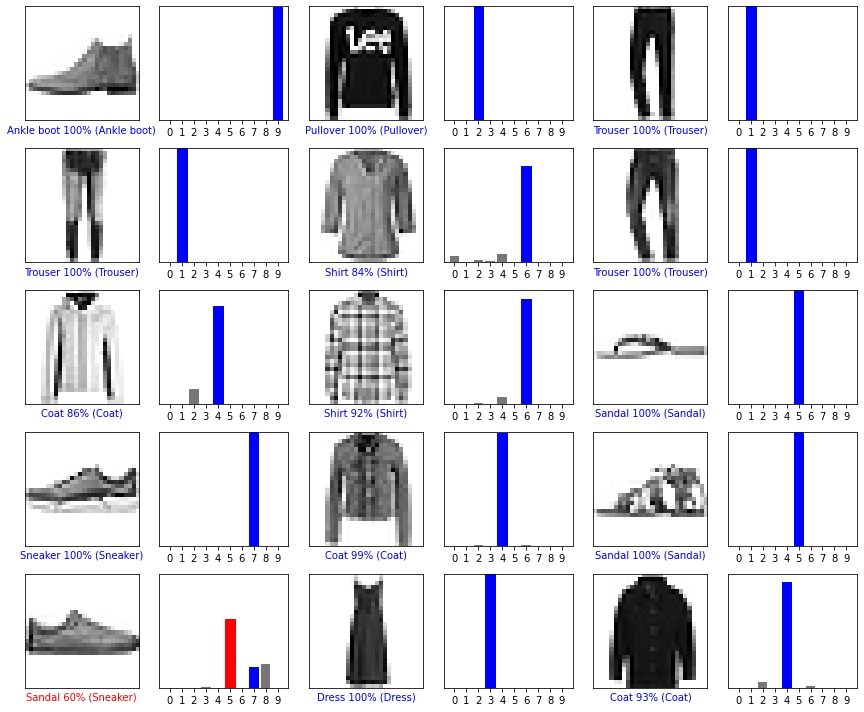

In [7]:
adaptive_probability_model = tf.keras.Sequential([adaptive_model, 
                                         tf.keras.layers.Softmax()])
adaptive_predictions = adaptive_probability_model.predict(ch_test_images)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, adaptive_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, adaptive_predictions[i], test_labels)
plt.tight_layout()
plt.show()

### You have completed Module 4-Lab 4

## Optional: Additional validation
If you want, you can compare the three models that you created in these labs on additional images:
- Const Model = The model you trained on 5 epochs on 1 GPU with no HPO
- Distributed Model = The model you trained on 12 epochs on 4 GPUs with no HPO
- Adaptive Model = The best model obtained when you trained on up to 12 epochs with Adaptive ASHA

Up to now you have been viewing images 1-15. 
Run the cell below to compare your three models on images 16-30. 
(If you want to compare on additional images, simply change the set number in line 1. Then run the cell again. You can keep changing the set number to see more images. The valid range is 0 to 665.)

Const Model Results for Images 15 to 30


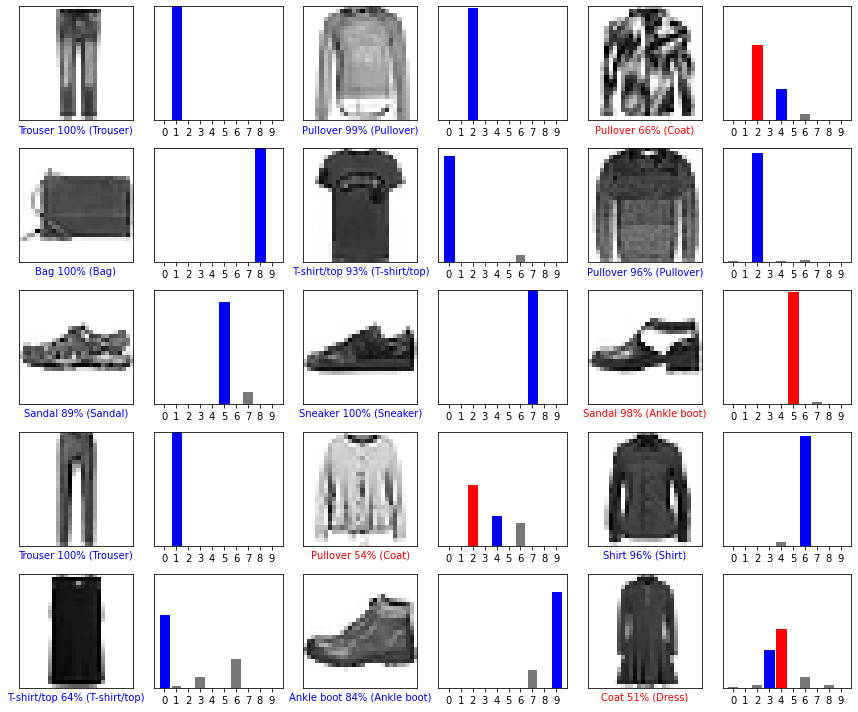




Distributed Model Results for Images 15 to 30


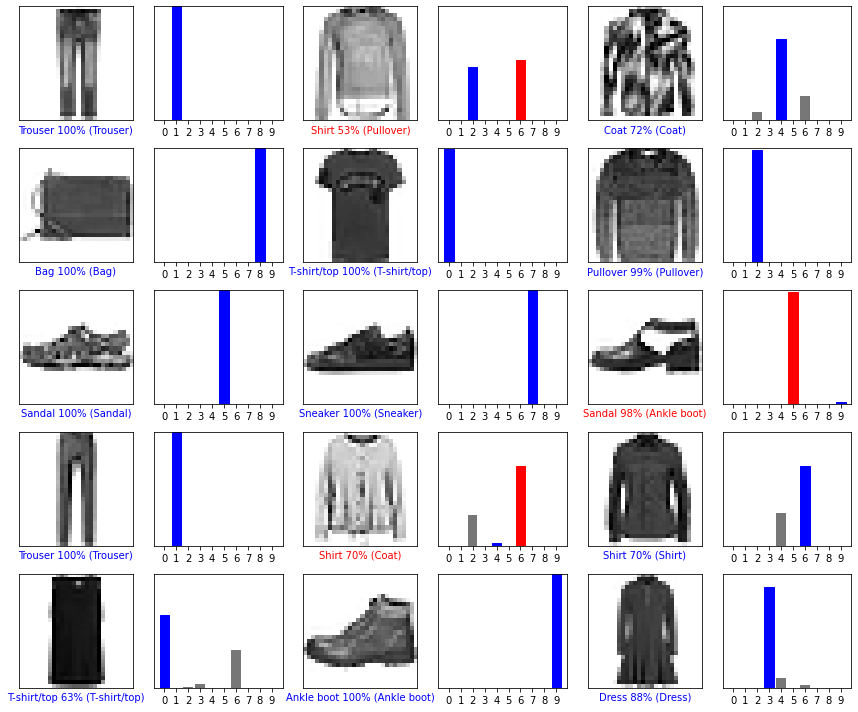




Adaptive Model Results for Images 15 to 30


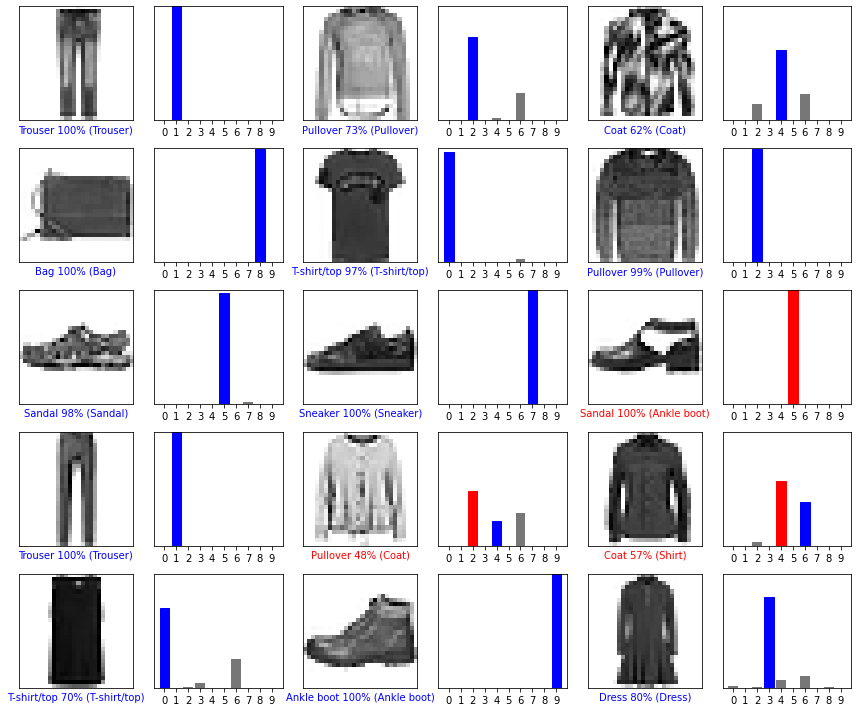

In [8]:
set = 1
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
start_image = (set*num_images)
end_image = (set*num_images)+num_images

print("\033[1m"+"Const Model Results for Images "+str(start_image)+" to "+str(end_image)+"\033[0m")
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, const_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, const_predictions[i], test_labels)
plt.tight_layout()
plt.show()
print()
print()
print()
print("\033[1m"+"Distributed Model Results for Images "+str(start_image)+" to "+str(end_image)+"\033[0m")
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, distributed_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, distributed_predictions[i], test_labels)
plt.tight_layout()
plt.show()
print()
print()
print()
print("\033[1m"+"Adaptive Model Results for Images "+str(start_image)+" to "+str(end_image)+"\033[0m")
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(start_image, end_image):
  index = i % num_images
  plt.subplot(num_rows, 2*num_cols, 2*index+1)
  plot_image(i, adaptive_predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*index+2)
  plot_value_array(i, adaptive_predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Optional: See the bind mount for this JupyterLab environment
The template that you use to run JupyterLab included a bind mount to the /tmp directory. This bind mount lets this Notebook access the validation images, as well as model checkpoints, saved to the shared file system. 
The cell below issues a det command (always preceded by ! in Notebooks) to show the config.
Replace ID with the long string in the brower tab between "proxy/" and "/lab." 
Then run the cell. 

In [9]:
!det notebook config id

Master not found at localhost:8080. Hint: Remember to set the DET_MASTER environment variable to the correct Determined master IP or use the '-m' flag.
Failed to display TensorBoard config: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /login (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fadc8e85fd0>: Failed to establish a new connection: [Errno 111] Connection refused',))
